In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState, SeedSequence
from numpy.random import MT19937
from keras.optimizers import adam_v2
from PIL import Image
from pathlib import Path
from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Input, BatchNormalization
from keras.regularizers import l2
import keras
from keras import backend as K
from sklearn.model_selection import train_test_split
from art.attacks.evasion import FastGradientMethod, FrameSaliencyAttack
from art.estimators.classification.keras import KerasClassifier
from art.utils import load_cifar10
import tensorflow as tf
from art.defences.preprocessor import JpegCompression, FeatureSqueezing, SpatialSmoothing

### Imagen de entrenamientos

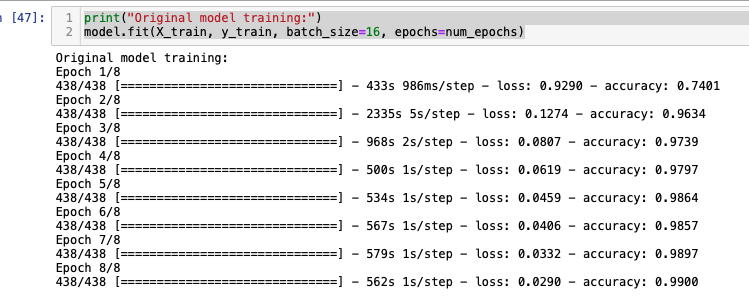

### Imagen de resultados

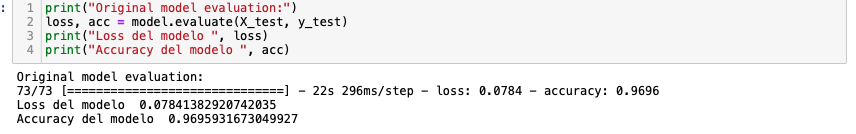

## Constantes

In [72]:
labels_mapped = [
    'Swizzor.gen!I',
    'Instantaccess',
    'Dialplatform.B',
    'Autorun.K',
    'Dontovo.A',
    'C2LOP.gen!g',
    'C2LOP.P',
    'Lolyda.AA1',
    'Lolyda.AT',
    'Adialer.C',
    'Fakerean',
    'Rbot!gen',
    'Allaple.A',
    'VB.AT',
    'Yuner.A','Malex.gen!J','Swizzor.gen!E','Agent.FYI','Skintrim.N','Obfuscator.AD','Lolyda.AA2','Lolyda.AA3','Wintrim.BX','Allaple.L', 'Alueron.gen!J']
    


In [18]:
def show_image_data(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Cargar data no conocida

Se utilizara la data que no se utilizo para entrenar el modelo en el laboratorio #7.
La razón por que se opto por este approach en lugar de utilizar data aleatoría es porque para la data aleatoría necesitariamos tener estratificado los resultados de los labels que los scamos realizando predicciones sobre el modelo general pero el modelo con data aleatoria tiende a retornar el label 12 (index 12) que corresponde a 'Allaple.A' que tiene un total de  2949  ejemplares.

In [2]:
images_resized = np.load('images_resized_clean.npy')
labels_np_real = np.load('labels_np_clean.npy')

#### Aleateorizamos la data

In [3]:
indices = np.random.permutation(len(images_resized))

In [4]:
size = 1000
stolen_images = images_resized[indices[:size]]
stolen_labels = labels_np_real[indices[:size]]
stolen_images_test = images_resized[indices[size:]]
stolen_labels_test = labels_np_real[indices[size:]]

### Cargada de modelo
Se carga el modelo inicial y se pone un mayor limite de recursión para permitir cargar el modelo

In [7]:
import sys
sys.setrecursionlimit(1500)
model_to_be_attacked_keras = tf.keras.models.load_model('model_v2')
tf.compat.v1.disable_eager_execution()
victim_keras = KerasClassifier(model_to_be_attacked_keras, clip_values=(0, 1), use_logits=False)

Nuestro ataque tendra una variación de 0.06 dentro de los valores para prevenir que la imagen cambie mucho

In [47]:
# craft adversarial attack with FGM
fgm = FastGradientMethod(
    victim_keras,
    eps=0.06, 
    batch_size=128,
    
)

In [48]:
images_sample = fgm.generate(
    x=stolen_images,
    y=stolen_labels
)

### Resultados

In [29]:
print("Número de imagenes generadas: ", len(images_sample))

Número de imagenes generadas:  1000


In [93]:
real_preds = np.argmax(victim_keras.predict(x=stolen_images), axis=1)

In [94]:
tampered_preds = np.argmax(victim_keras.predict(x=images_sample), axis=1)

In [95]:
acc = np.sum(real_preds != tampered_preds) / len(real_preds)
print("Porcentaje de accuracy de imagenes que fuerons clasificadas erroneamente: ", acc)

Porcentaje de accuracy de imagenes que fuerons clasificadas erroneamente:  0.902


In [96]:
wrong_mapped_by_class = {}
for l in labels_mapped:
    wrong_mapped_by_class[l] = 0
for index in tampered_preds[tampered_preds != real_preds]:
    wrong_mapped_by_class[labels_mapped[index]] += 1
    
print("Número de imagenes que lograrón evadir el modelo: ", np.sum(real_preds != tampered_preds))


Número de imagenes que lograrón evadir el modelo:  902


In [97]:


pd.DataFrame(data={
    'Número de imagenes que lograron evadir exitosamente': list(wrong_mapped_by_class.values()) }
            , index=list(wrong_mapped_by_class.keys()))

Número de imagenes que lograron evadir exitosamente
Swizzor.gen!I                                                  41  
Instantaccess                                                   0  
Dialplatform.B                                                  0  
Autorun.K                                                      87  
Dontovo.A                                                      10  
C2LOP.gen!g                                                    15  
C2LOP.P                                                        48  
Lolyda.AA1                                                     11  
Lolyda.AT                                                      16  
Adialer.C                                                       0  
Fakerean                                                        5  
Rbot!gen                                                        8  
Allaple.A                                                      72  
VB.AT                                                          36  
Yuner.A                                                         0  
Malex.gen!J                                                   318  
Swizzor.gen!E                                                  51  
Agent.FYI                                                       0  
Skintrim.N                                                      0  
Obfuscator.AD                                                   0  
Lolyda.AA2                                                     10  
Lolyda.AA3                                                      0  
Wintrim.BX                                                      0  
Allaple.L                                                     167  
Alueron.gen!J                                                   7

In [98]:
print("Número de imagenes que no lograrón evadir el modelo: ", np.sum(real_preds == tampered_preds))

Número de imagenes que no lograrón evadir el modelo:  98


### Visualización de imagenes

#### Label correcto

In [193]:
labels_mapped[np.argmax(stolen_labels[530])]

'Allaple.A'

#### Imagen alterada con el ataque de evasión

In [192]:
print("Se predijo que la siguiente imagen sería ", labels_mapped[tampered_preds[530]])

Se predijo que la siguiente imagen sería  Malex.gen!J


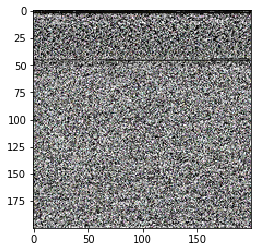

In [184]:
show_image_data(images_sample[530])

#### Imagen no alterada

In [185]:
print("Se predijo que la siguiente imagen sería ", labels_mapped[real_preds[530]])

Se predijo que la siguiente imagen sería  Allaple.A


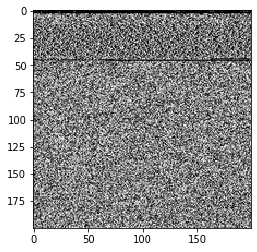

In [186]:
show_image_data(stolen_images[530])

### Resultados preeliminares
<br>
Notamos que la evasión fue exitosa con una variación de 0.06 en los input values. de 1000 imagenes generadas 902 lográron evadir el modelo representando u 90.2% de éxito siendo Malex.gen!J la clase mas evadida. El número de imagenes generadas que no lograón evadir fueron 98.
 <br>
<b>Resultados de las imagenes que tanto se alteraron?</b><br>
Si ya vimos que evadieron exitosamente el modelo su mayoría queremos observar que tanto cambiaron. Viendo la primer imagen alterada vs la imagen original notamos que se notan características similares entre ambos si se nota un poco diferente en ciertas partes pero aún se parece bastante y era una imágen que pertenecía al grupo de allaple. a y el modelo penso que era Malex.gen! J evadiendo correctamente el modelo.

# ¿Cómo podría proteger su modelo ante este tipo de ataques?

Hay varias maneras de protegernos de ataques de evasión podríamos utilizar uno de los modelos como Binary Input Detector que ya ART nos da para porimero ver si es una imagen alterada o no.
Como deseamos proteger el modelo utilizaremos la combinacion de varios pre procesadores dentro de nuestro claisificador.
<br>
**JpegCompression**<br>
Este modifica nuestro flujo en el modelo original agregando un layer de compresión de la imagen a JPEG variando dependiendo de un param de calidad de imagen. Debido a que no estamos re entrenando el modelo no se applica al fit.

Este nos ayuda a eliminar el ruido que los ataques generán en la imagen.
<br>
**FeatureSqueezing**<br>
Utilizamos este pre procesador para reducir la sensibilidad del modelo CNN al ruido que se genera.

# JpegCompression y FeatureSqueezing para proteger el modelo

In [161]:
protected = KerasClassifier(
    model_to_be_attacked_keras, 
    clip_values=(0, 1), 
    use_logits=False, 
    preprocessing_defences = [
        JpegCompression(clip_values=(0,1), apply_fit=False, verbose = True, quality = 5),
        FeatureSqueezing(clip_values=(0,1), apply_fit=False, bit_depth = 64)

    ]
)

In [162]:
fgm_protected = FastGradientMethod(
    protected,
    eps=0.06, 
    batch_size=128,
    
)

In [163]:
images_sample_protected = fgm_protected.generate(
    x=stolen_images,
    y=stolen_labels
)

JPEG compression: 0it [00:00, ?it/s]

JPEG compression: 0it [00:00, ?it/s]

JPEG compression: 0it [00:00, ?it/s]

JPEG compression: 0it [00:00, ?it/s]

JPEG compression: 0it [00:00, ?it/s]

JPEG compression: 0it [00:00, ?it/s]

JPEG compression: 0it [00:00, ?it/s]

JPEG compression: 0it [00:00, ?it/s]

In [164]:
tampered_preds_protected = np.argmax(protected.predict(x=images_sample_protected), axis=1)

JPEG compression: 0it [00:00, ?it/s]

### Resultados

In [165]:
acc = np.sum(real_preds != tampered_preds_protected) / len(real_preds)
print("Porcentaje de accuracy de imagenes que fuerons clasificadas erroneamente: ", acc)

Porcentaje de accuracy de imagenes que fuerons clasificadas erroneamente:  0.663


In [166]:
wrong_mapped_by_class = {}
for l in labels_mapped:
    wrong_mapped_by_class[l] = 0
for index in tampered_preds_protected[tampered_preds_protected != real_preds]:
    wrong_mapped_by_class[labels_mapped[index]] += 1
    
print("Número de imagenes que lograrón evadir el modelo: ", np.sum(real_preds != tampered_preds_protected))

Número de imagenes que lograrón evadir el modelo:  663


In [167]:
pd.DataFrame(data={
    'Número de imagenes que lograron evadir exitosamente': list(wrong_mapped_by_class.values()) }
            , index=list(wrong_mapped_by_class.keys()))

Número de imagenes que lograron evadir exitosamente
Swizzor.gen!I                                                   3  
Instantaccess                                                   0  
Dialplatform.B                                                  0  
Autorun.K                                                       0  
Dontovo.A                                                       0  
C2LOP.gen!g                                                   178  
C2LOP.P                                                       157  
Lolyda.AA1                                                      9  
Lolyda.AT                                                       3  
Adialer.C                                                       0  
Fakerean                                                        0  
Rbot!gen                                                        0  
Allaple.A                                                       0  
VB.AT                                                          27  
Yuner.A                                                         0  
Malex.gen!J                                                     2  
Swizzor.gen!E                                                   6  
Agent.FYI                                                       0  
Skintrim.N                                                      0  
Obfuscator.AD                                                   0  
Lolyda.AA2                                                      9  
Lolyda.AA3                                                     30  
Wintrim.BX                                                      1  
Allaple.L                                                     238  
Alueron.gen!J                                                   0

Notamos que ahora hay clases como Allaple.L que pudieron evadir mas pero también hay clases como Malex.gen!J que completamente se elimino el poder evadir de parte del modelo

In [168]:
print("Número de imagenes que no lograrón evadir el modelo: ", np.sum(real_preds == tampered_preds_protected))

Número de imagenes que no lograrón evadir el modelo:  337


Nuestro número de muestras que no lograron evadir el modelo prácticamente se cuadruplico mostrando una definitiva mejora pero aún con espacio a mejorar

### Visualización de imagenes

#### Label correcto

In [187]:
labels_mapped[np.argmax(stolen_labels[530])]

'Allaple.A'

#### Imagen alterada con el ataque de evasión

In [188]:
print("Se predijo que la siguiente imagen sería ", labels_mapped[tampered_preds_protected[530]])

Se predijo que la siguiente imagen sería  Allaple.L


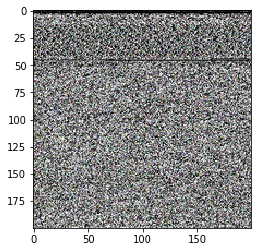

In [189]:
show_image_data(images_sample_protected[530])

#### Imagen no alterada

In [190]:
print("Se predijo que la siguiente imagen sería ", labels_mapped[real_preds[530]])

Se predijo que la siguiente imagen sería  Allaple.A


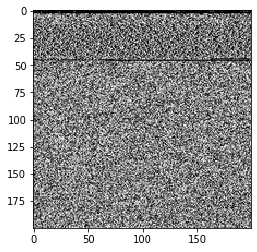

In [191]:
show_image_data(stolen_images[530])

### Resultados
Como podemos observar en la imagen alterada hay leves cambios en la parte media definitivamente se logro deucir el ruido con la compresión de la imagen. También a pesar de ellos con la desensibilacioón de features en nuestro modelo logramos determinar correctamente que es el virus 'Allaple.A'.
<br>
Respecto a nuestor modelo anterior notamos que su efectividad bajo de 90% a 66% de efictividad de evasión en el modelo. Mejorando notablemente en el número de Malex.gen!J que lograron evadir el modelo.
El proceso que más nos ayudo tras varias pruebas fue el de la compresión de la imagen a JPEG para reducir el ruido.<br><br>
<b>Resultados de las imagenes que tanto se alteraron?</b><br>
Notamos que en la parte superior la imagen fue levemente menos alterada. Y con la desensibilización de features logramos que prediga correctamente

## Recomencaciones
Se recomienda para poder mejorar el modelo re entrenar el modelo con imagenes con ruido y con labels correctos para desensibilizar también de estos ataques.
Tambien se genera re entrenar este modelo con las defensas que se le implementaron.

# Conclusiones

- El ataque de evasión permite a modelos de clasificar correctamente un input agregando ruido al mismo.
- Es importante tomar en cuenta desde un inicio al crear el modelo los posibles ataques que pueda sufrir. Como se pudo haber entrenado el modelo expandiendo el dataset con data generada con ruido y labels correctos.
- Agregar al pipeline del modelo diferentes métodos de protección en el momento de entrenamiento es importante para mejorar.